In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import skimage

OUTPUT_DIR = "output"

#Add ImageJ to search path (named ImageJ-linux64)
sitk.ImageViewer().SetGlobalDefaultSearchPath((*sitk.ImageViewer().GetGlobalDefaultSearchPath(),'/home/gatocor/'))
image_viewer = sitk.ImageViewer()

Make a reader to load just a specific region.

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


Text(0.5, 1.0, 'Just interesting region loaded')

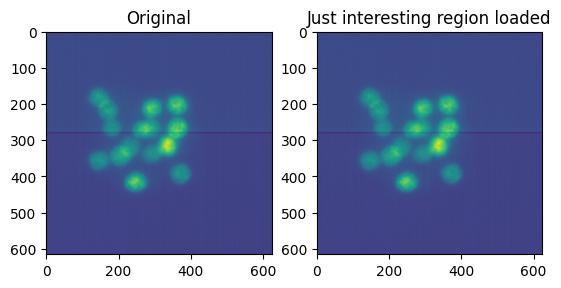

In [2]:
name_file = "example/0.tif" #Set

file_reader = sitk.ImageFileReader()
file_reader.SetFileName(name_file)
file_reader.ReadImageInformation() #Read infor without uploading file

#Set lims
xlims = (50,500)
ylims = (100,500)
zlims = (0,file_reader.GetSize()[2])

# read the image information without reading the bulk data, compute ROI start and size and read it.
start_index = (xlims[0],ylims[0],zlims[0])
extract_size = (xlims[1]-xlims[0],ylims[1]-ylims[0],zlims[1]-zlims[0])
# file_reader.SetExtractIndex(start_index)
# file_reader.SetExtractSize(extract_size)
# file_reader.SetOutputPixelType(sitk.sitkFloat32)

image_3D_original = sitk.ReadImage(name_file, sitk.sitkFloat32)

arr = sitk.GetArrayFromImage(image_3D_original)
image_3D = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])

fig,ax = plt.subplots(1,2)
ax[0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[0].set_title("Original")
ax[1].imshow(sitk.GetArrayFromImage(file_reader.Execute()).sum(axis=0))
ax[1].set_title("Just interesting region loaded")

Load image and set the appropiate spacing

In [3]:
# #Load the box region
# image_3D = file_reader.Execute()
# #Set physical space
# image_3D.SetSpacing([1,1,4]) #deltaX...
# image_3D.SetOrigin((0,0,0)) #origin of the image to rotate, transale etc.

Threshold background. This step may not be necessary but when performing rotations translations etc, then there are regions with all zeros. To make it homogeneous, I remove those pixels values to look it nicer.

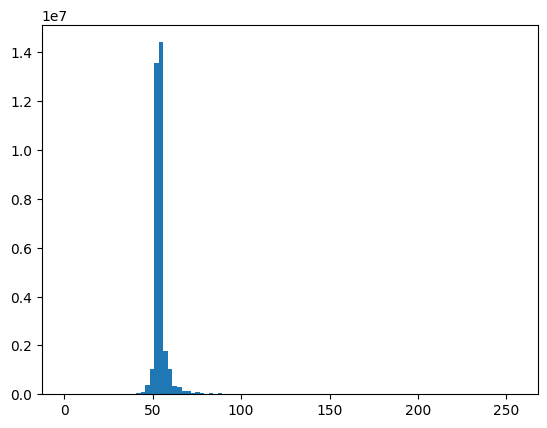

In [4]:
#to choose a threshold of the background noise
plt.hist(sitk.GetArrayFromImage(image_3D_original).flatten(),bins=100)
plt.show()

In [5]:
arr = sitk.GetArrayFromImage(image_3D_original)
print
image_3D_thresholded = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])
image_3D_thresholded.CopyInformation(image_3D) #use sampe parameters as the original figure
image_3D_thresholded[image_3D<70] = 0

image_3D_original_thresholded = sitk.ReadImage(name_file, sitk.sitkFloat32)
image_3D_original_thresholded.CopyInformation(image_3D_original)
image_3D_original_thresholded[image_3D_original<70] = 0


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


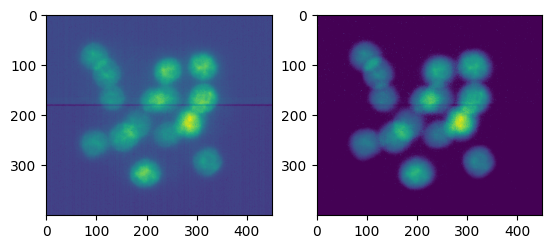

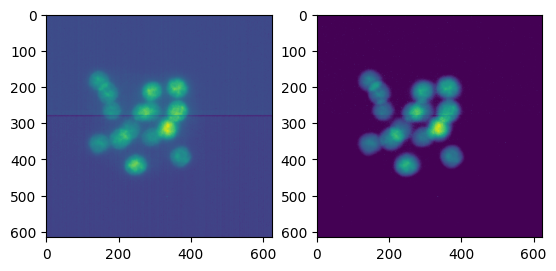

In [6]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(sitk.GetArrayFromImage(image_3D).sum(axis=0))
ax[1].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))

fig,ax = plt.subplots(1,2)

ax[0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[1].imshow(sitk.GetArrayFromImage(image_3D_original_thresholded).sum(axis=0))

# Transform

Make a random transformation.

In [7]:
rot_ax= (0,0,1)
rot_angle = 0.1*np.pi
trans = [0,10,0]

img_center = (image_3D_original_thresholded.GetHeight()/2,image_3D_original_thresholded.GetWidth()/2,image_3D_original_thresholded.GetDepth()/2)
#Rotation
transform = sitk.VersorTransform(rot_ax,rot_angle, img_center)
#Translation
transform2 = sitk.TranslationTransform(3,trans)
#Put together
transform_total = sitk.CompositeTransform([transform,transform2])
#Create image

image_3D_original_transformed = sitk.Resample(image_3D_original, transform_total)
image_3D_original_thresholded_transformed = sitk.Resample(image_3D_original_thresholded, transform_total)

arr = sitk.GetArrayFromImage(image_3D_original_transformed)
image_3D_transformed = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])

arr = sitk.GetArrayFromImage(image_3D_original_thresholded_transformed)
image_3D_thresholded_transformed = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])

Text(0.5, 1.0, 'thresholded and transformed')

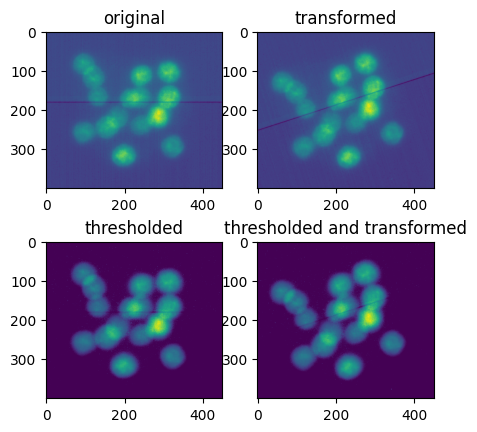

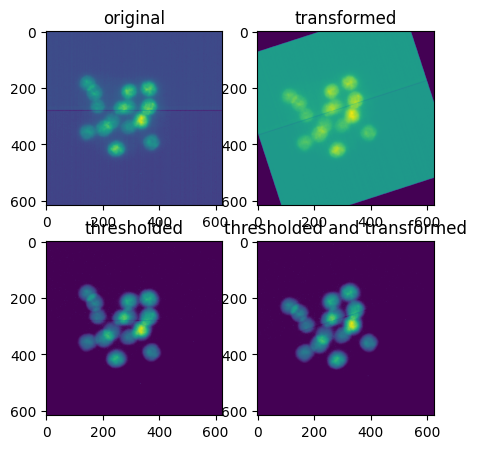

In [8]:
fig,ax = plt.subplots(2,2,figsize=(5,5))

ax[0,0].imshow(sitk.GetArrayFromImage(image_3D).sum(axis=0))
ax[0,0].set_title("original")
ax[0,1].imshow(sitk.GetArrayFromImage(image_3D_transformed).sum(axis=0))
ax[0,1].set_title("transformed")
ax[1,0].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))
ax[1,0].set_title("thresholded")
ax[1,1].imshow(sitk.GetArrayFromImage(image_3D_thresholded_transformed).sum(axis=0))
ax[1,1].set_title("thresholded and transformed")


fig,ax = plt.subplots(2,2,figsize=(5,5))

ax[0,0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[0,0].set_title("original")
ax[0,1].imshow(sitk.GetArrayFromImage(image_3D_original_transformed).sum(axis=0))
ax[0,1].set_title("transformed")
ax[1,0].imshow(sitk.GetArrayFromImage(image_3D_original_thresholded).sum(axis=0))
ax[1,0].set_title("thresholded")
ax[1,1].imshow(sitk.GetArrayFromImage(image_3D_original_thresholded_transformed).sum(axis=0))
ax[1,1].set_title("thresholded and transformed")

Registration

In [9]:
#Set what image is used as a reference and which is transformed
fixed_image = image_3D_thresholded

moving_image = image_3D_thresholded_transformed


In [10]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM) #NONE uses all pints, RANDOM downscales them
registration_method.SetMetricSamplingPercentage(0.01) #Percentage of downscaling

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=0.005,
    numberOfIterations=500,
    convergenceMinimumValue=1e-7,
    convergenceWindowSize=100,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

#Transform this initializer, 
# (If you do not put it, nothing happens, 
# I have to explore more what it does, I guess this specifies which transformation optimize (Euler3DTransform roations now)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)
# Don't optimize in-place, we would possibly like to run this cell multiple times. 
registration_method.SetInitialTransform(initial_transform, inPlace=False)

#You can add something to plot during optimization
def f(registration_method):
    print("loss: ",registration_method.GetMetricValue())
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: f(registration_method)
)

# Run the fitting and get the transform
final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print("Final metric value: {0}".format(registration_method.GetMetricValue()))
print(
    "Optimizer's stopping condition, {0}".format(
        registration_method.GetOptimizerStopConditionDescription()
    )
)

loss:  -0.0608625869031395
loss:  -0.06196188398539756
loss:  -0.06286766292086579
loss:  -0.06380001012189304
loss:  -0.06472256905952192
loss:  -0.06553801284560902
loss:  -0.06631174459702763
loss:  -0.06704681169390164
loss:  -0.06793748164005937
loss:  -0.06900629514526448
loss:  -0.06926609224527412
loss:  -0.0712100344784257
loss:  -0.07234871594532914
loss:  -0.07350989469742604
loss:  -0.0751050491605384
loss:  -0.07572060708070255
loss:  -0.07723672219120417
loss:  -0.07814919391072049
loss:  -0.07955055542306856
loss:  -0.0807846896982354
loss:  -0.08178029469118021
loss:  -0.08324128388597378
loss:  -0.08432720800100668
loss:  -0.0853245502439159
loss:  -0.08659362121301048
loss:  -0.08792680741490144
loss:  -0.08899820569824629
loss:  -0.09042829383345682
loss:  -0.09196344340499096
loss:  -0.09347267027682085
loss:  -0.09452133647543949
loss:  -0.09607023302734104
loss:  -0.0975199212170939
loss:  -0.09912285173892259
loss:  -0.1004617530003438
loss:  -0.10219529390521363

In [21]:
tr = sitk.CompositeTransform([final_transform])
# tr = transform_total.GetInverse()
image_3D_corrected = sitk.Resample(image_3D_thresholded_transformed, tr)
idxs = (-1*start_index[0], -1*start_index[1], -1*start_index[2])
image_3D_original_thresholded_transformed.SetOrigin((idxs))
image_3D_original_corrected = sitk.Resample(image_3D_original_thresholded_transformed, tr)


Text(0.5, 1.0, 'Corrected')

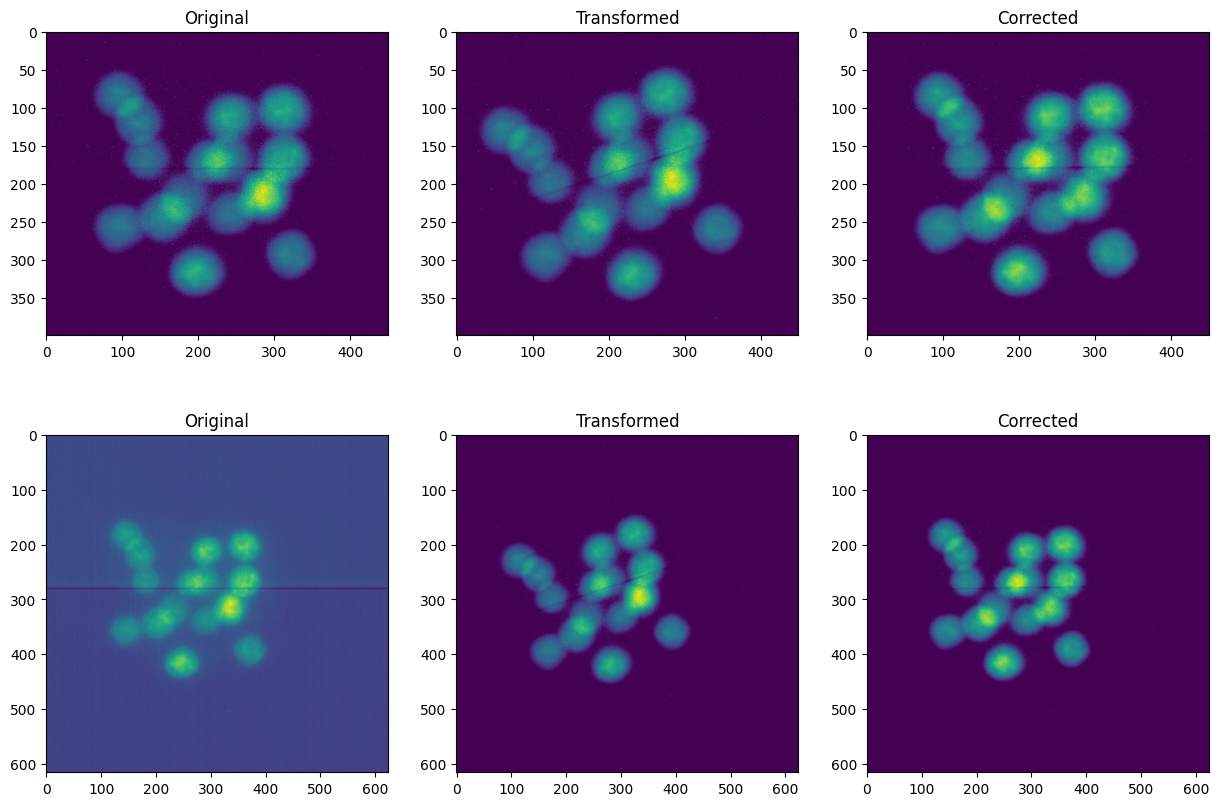

In [22]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

ax[0,0].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))
ax[0,0].set_title("Original")
ax[0,1].imshow(sitk.GetArrayFromImage(image_3D_thresholded_transformed).sum(axis=0))
ax[0,1].set_title("Transformed")
ax[0,2].imshow(sitk.GetArrayFromImage(image_3D_corrected).sum(axis=0))
ax[0,2].set_title("Corrected")

ax[1,0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[1,0].set_title("Original")
ax[1,1].imshow(sitk.GetArrayFromImage(image_3D_original_thresholded_transformed).sum(axis=0))
ax[1,1].set_title("Transformed")
ax[1,2].imshow(sitk.GetArrayFromImage(image_3D_original_corrected).sum(axis=0))
ax[1,2].set_title("Corrected")

(50.0, 100.0, 0.0)
(50.0, 100.0, 0.0)


Text(0.5, 1.0, 'Corrected')

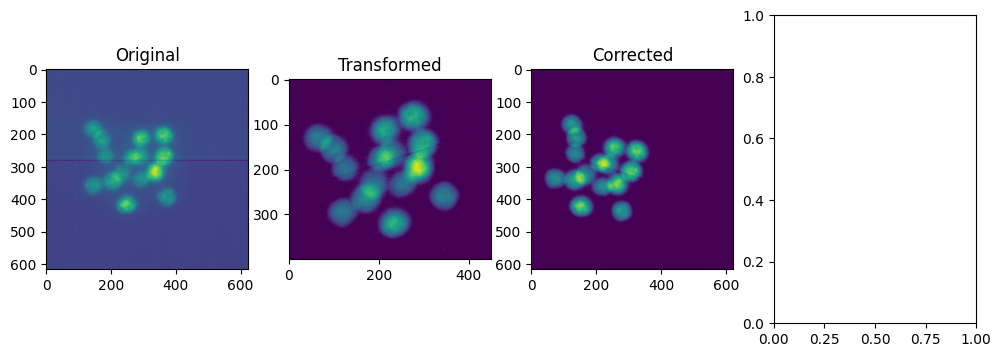

In [166]:
new_indexes = (start_index[1], start_index[0], start_index[2])
print(image_3D_original.GetOrigin())
image_3D_original.SetOrigin(start_index)
print(image_3D_original.GetOrigin())
image_3D_corrected = sitk.Resample(image_3D_original_thresholded, sitk.CompositeTransform([final_transform]))

fig,ax = plt.subplots(1,4,figsize=(12,4))

ax[0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[0].set_title("Original")
ax[2].imshow(sitk.GetArrayFromImage(image_3D_corrected).sum(axis=0))
ax[2].set_title("Corrected")
ax[1].imshow(sitk.GetArrayFromImage(image_3D_thresholded_transformed).sum(axis=0))
ax[1].set_title("Transformed")
ax[2].imshow(sitk.GetArrayFromImage(image_3D_corrected).sum(axis=0))
ax[2].set_title("Corrected")